# 5. 가위바위보 분류기 만들기


### 목표  
- 이미지 분류기를 keras 를 활용하여 제작하기 
- 오버피팅을 극복하기 위해 적절한 시도 (데이터셋 다양화, 정규화 등) 해보기
- 분류모델의 test accuracy 60% 이상 달성하기 


## (1) 라이브러리 import 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import numpy as np
from PIL import Image
import os
import glob


## (2) 데이터 불러오기 + Resize 하기 

- 가위 바위 보 차례대로 28 x 28 사이즈로 변경

In [2]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [3]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


In [4]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
보 이미지 resize 완료!


In [5]:
#가위바위보 라벨링 

def load_data(img_path, number_of_data=300):  
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


- Load한 데이터를 train data : 80%, validation_data : 10%, test_data : 10% 의 비율로 나누기

In [6]:
total_x, total_y = x_train_norm, y_train
leng_x, leng_y = len(total_x), len(total_y)
x_train, x_valid, x_test= total_x[:int(leng_x*0.8)], total_x[int(leng_x*0.8):int(leng_x*0.9)], total_x[int(leng_x*0.9):]
y_train, y_valid, y_test= total_y[:int(leng_y*0.8)], total_y[int(leng_y*0.8):int(leng_y*0.9)], total_y[int(leng_y*0.9):]

라벨:  0


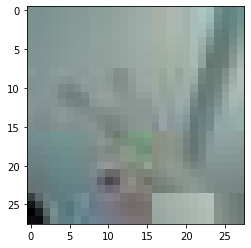

In [7]:
# 라벨링이 제대로 됐는지 확인

plt.imshow(x_train[1])
print('라벨: ', y_train[1])

- 라벨 0 은 가위를 말하는데, 가위 사진이 나와 데이터가 제대로 라벨링 된 것을 확인

## (3) 딥러닝 네트워크 설계하기


In [8]:
# Sequential model 을 사용 

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu')) # 중간의 Dense만 50으로 변경
model.add(keras.layers.Dense(3, activation='softmax'))

print('- Model에 추가된 Layer 개수: ', len(model.layers))

- Model에 추가된 Layer 개수:  7


In [9]:
# 모델 정보 확인 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                40050     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1

## (4) 딥러닝 네트워크 학습시키기 

In [22]:
# model을 학습시키는 코드 작성

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
history1 = model.fit(x_train,y_train, epochs=15)

Epoch 1/15
10/10 [==============================] - 1s 19ms/step - loss: 0.3829 - accuracy: 0.8800
Epoch 2/15
10/10 [==============================] - 0s 22ms/step - loss: 0.1880 - accuracy: 0.9267
Epoch 3/15
10/10 [==============================] - 0s 22ms/step - loss: 0.1301 - accuracy: 0.9533
Epoch 4/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0393 - accuracy: 0.9867
Epoch 5/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 6/15
10/10 [==============================] - 0s 19ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 7/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0065 - accuracy: 1.0000
Epoch 8/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 9/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 10/15
10/10 [==============================] - 0s 22ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 11/

In [23]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 119ms/step - loss: 1.0894 - accuracy: 0.5667


[1.089425802230835, 0.5666666626930237]

## (5) 성능확인을 위한 시각화

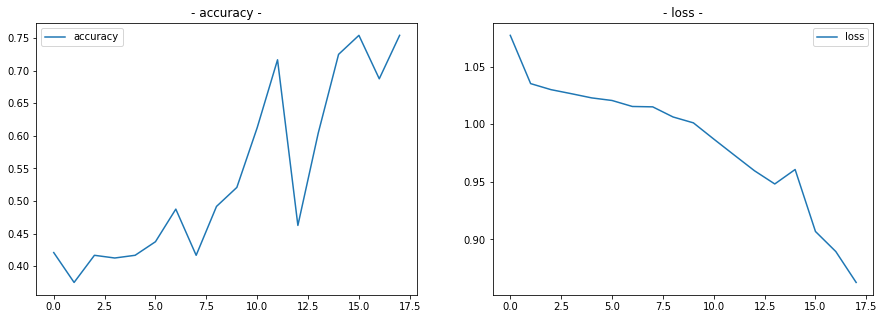

In [12]:
plt.figure(figsize=(15, 5))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history1.history["accuracy"], label="accuracy")
plt.title("- accuracy -")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history1.history["loss"], label="loss")
plt.title("- loss -")
plt.legend()

plt.show()

- 정확도 그래프는 전체적으로 올라가는 추세이기는 하나 뚝 떨어졌다 급격히 올라가는게 반복되었고 너무 굴곡이 심하여 정상범주로 보이지 않는다. 0.5667 으로 수치상으로도 효율은 저조하다.  

- loss 값 또한 전체적으로 떨어지는 추세이긴 커브가 반대로 뒤집힌 형상이다. 

## (6) 데이터 수 추가 

- 다른 분들이 올려주신 추가 데이터를 사용해 더 좋은 네트워크를 만들어 보기
- 데이터도 다시 resize 해주기
- 라벨링 다시 해주기 

In [13]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!


In [14]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


In [15]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
보 이미지 resize 완료!


라벨:  0


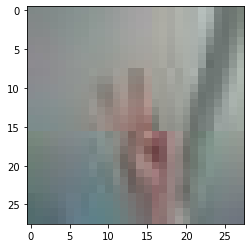

In [16]:
import matplotlib.pyplot as plt


plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [17]:


import numpy as np

def load_data(img_path, number_of_data=300):  
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


## (6) 딥러닝 네트워크 학습시키기 

In [18]:
# Sequential model 을 사용 

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu')) # Dnese 만 100으로 변경
model.add(keras.layers.Dense(3, activation='softmax'))


# 모델 정보 확인

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               80100     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [19]:
# model을 학습시키는 코드 작성

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
history2 = model.fit(x_train,y_train, validation_data=(x_valid, y_valid), epochs=20)

Epoch 1/20
10/10 [==============================] - 1s 38ms/step - loss: 16.7362 - accuracy: 0.3333 - val_loss: 1.0803 - val_accuracy: 1.0000
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 3.8220 - accuracy: 0.3600 - val_loss: 1.0913 - val_accuracy: 0.5333
Epoch 3/20
10/10 [==============================] - 0s 25ms/step - loss: 1.4768 - accuracy: 0.4433 - val_loss: 1.0926 - val_accuracy: 0.9333
Epoch 4/20
10/10 [==============================] - 0s 26ms/step - loss: 0.7985 - accuracy: 0.6500 - val_loss: 1.0983 - val_accuracy: 0.5000
Epoch 5/20
10/10 [==============================] - 0s 22ms/step - loss: 0.5696 - accuracy: 0.7867 - val_loss: 1.0980 - val_accuracy: 0.3667
Epoch 6/20
10/10 [==============================] - 0s 24ms/step - loss: 0.3744 - accuracy: 0.9000 - val_loss: 1.0980 - val_accuracy: 0.4333
Epoch 7/20
10/10 [==============================] - 0s 23ms/step - loss: 0.2299 - accuracy: 0.9267 - val_loss: 1.0952 - val_accuracy: 0.5333
Epoch 8/20
1

In [20]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 1.0817 - accuracy: 0.9333


[1.081659197807312, 0.9333333373069763]

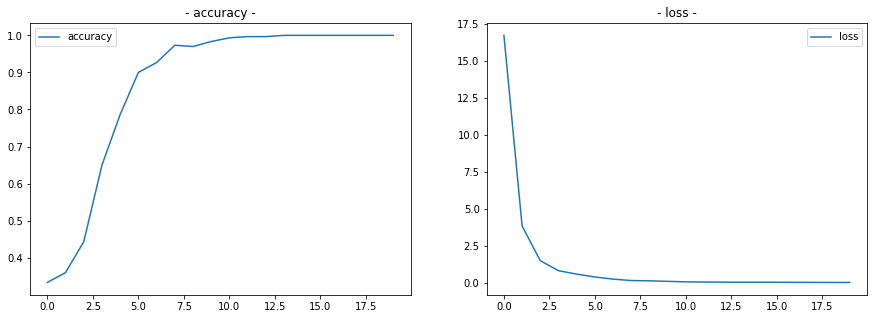

In [21]:
plt.figure(figsize=(15, 5))

# 에포크별 정확도
plt.subplot(1,2,1)
plt.plot(history2.history["accuracy"], label="accuracy")
plt.title("- accuracy -")
plt.legend()

# 에포크별 손실률
plt.subplot(1,2,2)
plt.plot(history2.history["loss"], label="loss")
plt.title("- loss -")
plt.legend()

plt.show()

- accuracy 값이 0.9333 이라는 수치가 나왔지만 loss 값은 크게 변하지 않았는데 noise 때문인걸로 짐작한다. Accuracy 그래프 중간에 살짝 오버피트가 난것 같지만 전체적으로 올라가는 형상을 보여 괜찮은것 같다.
 

## 회고 


#### 1 번째 그래프

- Loss 값 : 1.0894
- Accuracy : 0.5667


- 정확도 그래프는 전체적으로 올라가는 추세이기는 하나 뚝 떨어졌다 급격히 올라가는게 반복되었고 너무 굴곡이 심하여 정상범주로 보이지 않는다. 0.5333 으로 수치상으로도 효율은 저조하다.  

- loss 값 또한 높은편이며 그래프가 전체적으로 값이 떨어지는 추세이긴 커브가 반대로 뒤집힌 형상이다. 중간에 돌출된 부분이 있는데 오버피팅으로 짐작된다. 


#### 2번째 그래프 

- loss값 : 1.0817
- accuracy : 0.9333



- accuracy 그래프는 dense 를 100 으로 바꾸고 epoch 를 20 으로 변경

- 다행이 처음보다는 accuracy 값이 올라가 0.9333 이라는 수치가 나와줬고 목표였던 60% 이상을 달성했지만 loss 값은 조금 낮아졌는데 noise 때문인걸로 짐작한다. epoch 는 15, 18, 25, 20 으로 변경하면서 맞췄다. Accuracy 그래프 중간에 살짝 오버피트가 난것 같지만 전체적으로 올라가는 형상을 보여 괜찮은것 같다. 


#### 느낀점 
- 추가 데이터를 사용하고 하이퍼 파라미터를 조절하여 accuracy 를 높이긴 했지만, dense와 epoch 만 변경한 것이라 더 상세히 하이퍼 파라미터간의 상관관계를 확인하려면 많은 연습이 필요한 것 같다. 단기간에는 힘들겠지만 텐서플로우와 케라스에 더 익숙해져 라미터들을 능숙히 다룰 수 있도록 많은 노력을 해야할 것 같다.
